In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, cross_val_score, ShuffleSplit, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.manifold import TSNE

In [2]:
df = pd.read_csv('./Chronic_Kidney_Dsease_data.csv',index_col="PatientID")
df

,Age,Gender,Ethnicity,SocioeconomicStatus,EducationLevel,BMI,Smoking,AlcoholConsumption,PhysicalActivity,DietQuality,...,Itching,QualityOfLifeScore,HeavyMetalsExposure,OccupationalExposureChemicals,WaterQuality,MedicalCheckupsFrequency,MedicationAdherence,HealthLiteracy,Diagnosis,DoctorInCharge
PatientID,,,,,,,,,,,,,,,,,,,,,
1,71,0,0,0,2,31.069414,1,5.128112,1.676220,0.240386,...,7.556302,76.076800,0,0,1,1.018824,4.966808,9.871449,1,Confidential
2,34,0,0,1,3,29.692119,1,18.609552,8.377574,6.503233,...,6.836766,40.128498,0,0,0,3.923538,8.189275,7.161765,1,Confidential
3,80,1,1,0,1,37.394822,1,11.882429,9.607401,2.104828,...,2.144722,92.872842,0,1,1,1.429906,7.624028,7.354632,1,Confidential
4,40,0,2,0,1,31.329680,0,16.020165,0.408871,6.964422,...,7.077188,90.080321,0,0,0,3.226416,3.282688,6.629587,1,Confidential
5,43,0,1,1,2,23.726311,0,7.944146,0.780319,3.097796,...,3.553118,5.258372,0,0,1,0.285466,3.849498,1.437385,1,Confidential
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1655,90,0,0,1,2,39.677059,1,1.370151,4.157954,8.602873,...,2.138976,81.102765,0,0,0,0.951836,9.547583,2.046212,0,Confidential
1656,34,0,0,2,1,28.922015,0,3.372073,9.647525,9.836919,...,7.911566,10.600428,0,1,0,3.604147,1.609847,0.324417,0,Confidential
1657,84,0,0,2,3,21.951219,0,15.825955,7.349964,5.038194,...,0.015531,69.633427,0,0,0,0.801955,5.768617,4.935108,0,Confidential


In [3]:
df.drop(columns = 'DoctorInCharge',inplace=True)

<AxesSubplot:>

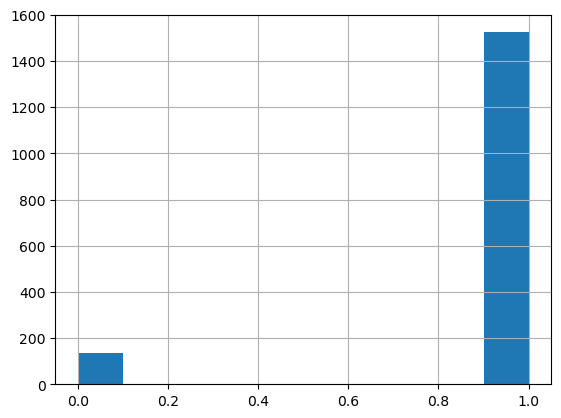

In [4]:
df["Diagnosis"].hist()

# 데이터불균형 처리
* Oversampling
* SMOTE

In [5]:
smo = SMOTE(random_state=1004)
X = df.drop("Diagnosis", axis=1)
Y = df["Diagnosis"]

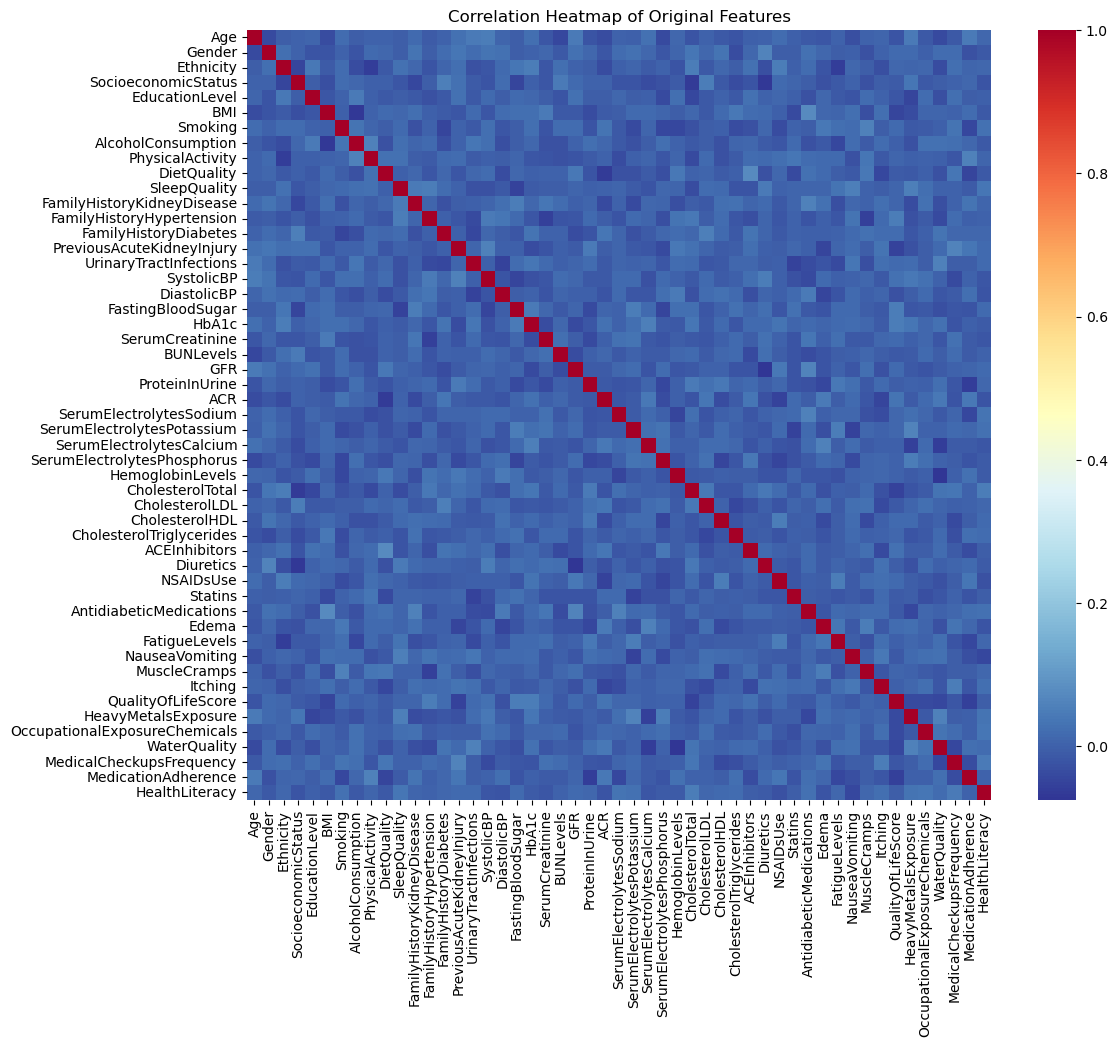

In [6]:
# Correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(X.corr(), cmap='RdYlBu_r')
plt.title('Correlation Heatmap of Original Features')
plt.show()

In [7]:
X_resampled,Y_resampled = smo.fit_resample(X,Y)

<AxesSubplot:>

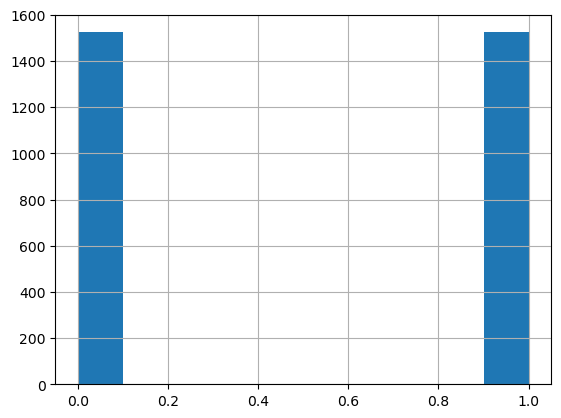

In [8]:
Y_resampled.hist()

In [12]:
from collections import Counter
print(f"Before resample: {dict(Counter(Y))}, After resample: {dict(Counter(Y_resampled))}")


Before resample: {1: 1524, 0: 135}, After resample: {1: 1524, 0: 1524}


# Feature Selection

In [13]:
clf = ExtraTreesClassifier(n_estimators=3000, random_state=42)
clf = clf.fit(X_resampled, Y_resampled)
model = SelectFromModel(clf, prefit=True, max_features=20)
X_new = model.transform(X_resampled)

feature_idx = model.get_support()
feature_name = X_resampled.columns[feature_idx]
df_selected = pd.DataFrame(X_new, columns=feature_name)

/home/zoo/miniconda3/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


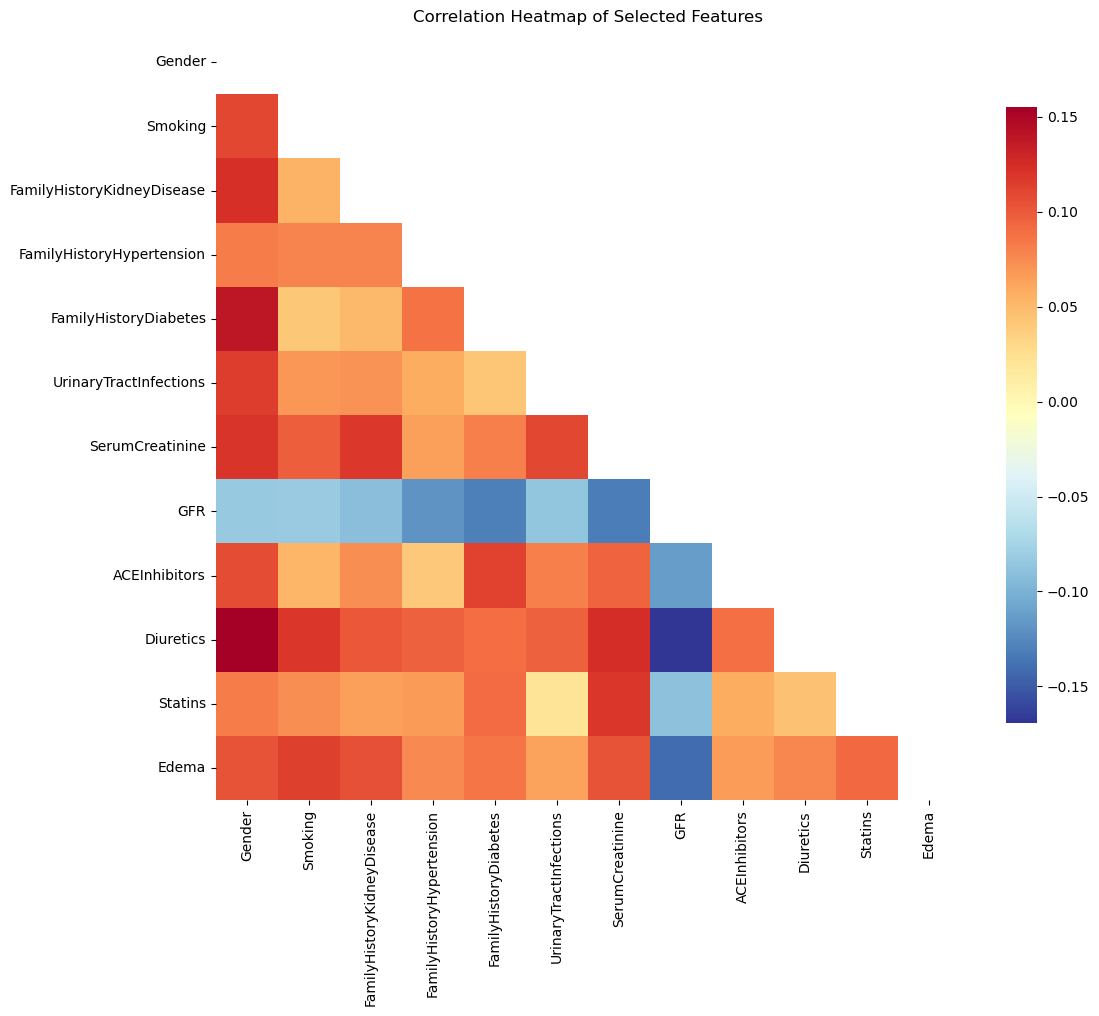

In [14]:
df_cor = df_selected.corr()
mask = np.triu(np.ones_like(df_cor, dtype=bool))
plt.figure(figsize=(12, 10))
sns.heatmap(df_cor, cmap='RdYlBu_r', mask=mask, annot=False, cbar_kws={"shrink": .8})
plt.title('Correlation Heatmap of Selected Features')
plt.show()

# Model generation

/home/zoo/miniconda3/lib/python3.10/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


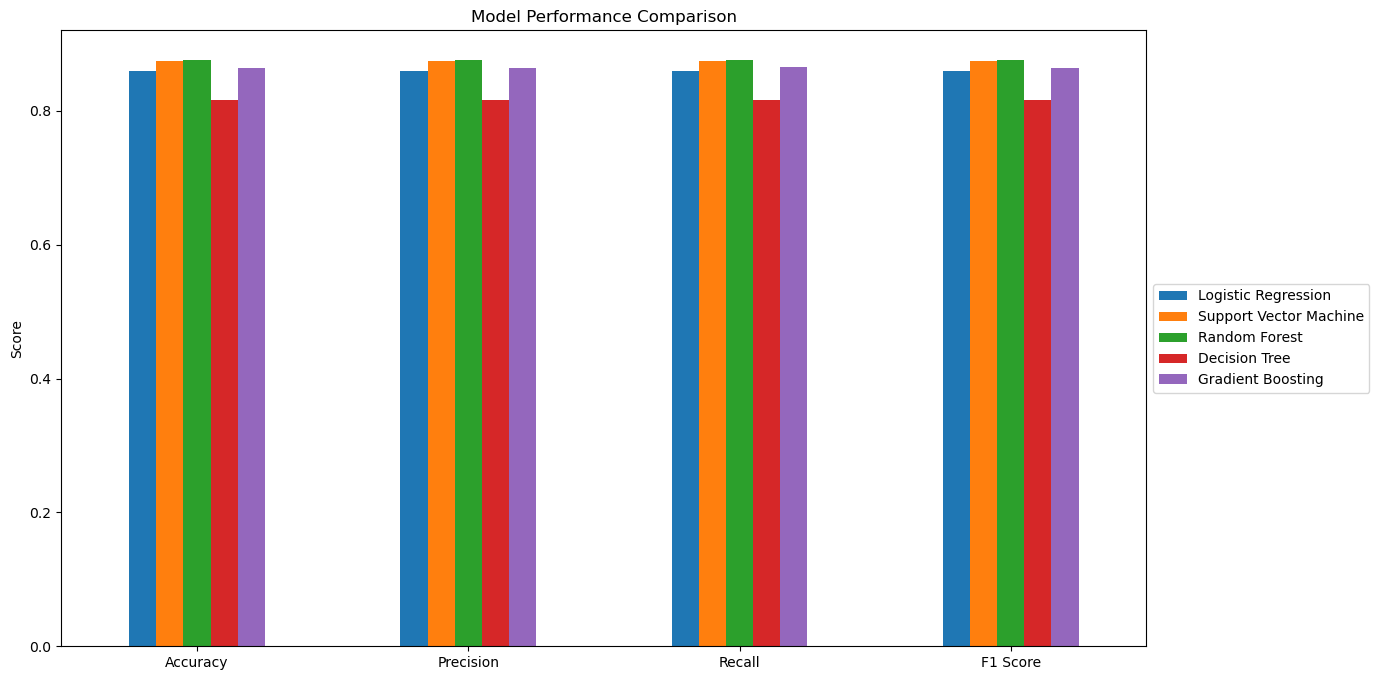

In [17]:
# data scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_selected)

# Prepare train and test sets (3:1)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y_resampled, test_size=0.25, random_state=42)

# Function to evaluate model performance and return metrics
def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')
    return accuracy, precision, recall, f1

# Models
models = {
    'Logistic Regression': LogisticRegression(max_iter=500),
    'Support Vector Machine': svm.SVC(max_iter=500),
    'Random Forest': RandomForestClassifier(n_estimators=500),
    'Decision Tree': DecisionTreeClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=500)
}

# Evaluate models and store results
results = {}
for name, model in models.items():
    accuracy, precision, recall, f1 = evaluate_model(model, X_train, X_test, y_train, y_test)
    results[name] = [accuracy, precision, recall, f1]

# Convert results to DataFrame
results_df = pd.DataFrame(results, index=['Accuracy', 'Precision', 'Recall', 'F1 Score'])

# Plot performance metrics for each model
results_df.plot(kind='bar', figsize=(14, 8), title="Model Performance Comparison")
plt.xticks(rotation=0)
plt.ylabel('Score')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#plt.savefig('model performance Comparison.png',dpi=350,bbox_inches='tight')

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold, LeaveOneOut, ShuffleSplit, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score
from tqdm import tqdm
# Define the models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Support Vector Machine': svm.SVC(max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=1000),
    'Decision Tree': DecisionTreeClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=1000)
}

# Define cross-validation methods
cv_methods = {
    'k-Fold (10 folds)': KFold(n_splits=10),
    'StratifiedKFold': StratifiedKFold(n_splits=10),
    'ShuffleSplit': ShuffleSplit(n_splits=10, test_size=0.3, random_state=0)
}
# Define scoring metrics
scoring = {
    'accuracy': 'accuracy',
    'precision': make_scorer(precision_score, average='macro'),
    'recall': make_scorer(recall_score, average='macro'),
    'f1': make_scorer(f1_score, average='macro')
}

# Function to evaluate model using cross-validation
def cross_val_evaluation(model, X, y, cv, scoring):
    scores = {metric: cross_val_score(model, X, y, cv=cv, scoring=scorer) for metric, scorer in scoring.items()}
    return {metric: (values.mean(), values.std()) for metric, values in scores.items()}

# Evaluate models using different validation methods and scoring metrics
cv_results = {method: {metric: {} for metric in scoring} for method in cv_methods}
for method, cv in tqdm(cv_methods.items()):
    for name, model in tqdm(models.items()):
        results = cross_val_evaluation(model, X_scaled, Y_resampled, cv, scoring)
        for metric, (mean, std) in results.items():
            cv_results[method][metric][name] = [mean, std]

# Convert cross-validation results to DataFrame
cv_results_df = {method: {metric: pd.DataFrame(results, index=['Mean', 'Std']).T for metric, results in metrics.items()} for method, metrics in cv_results.items()}

# Combine all results into a single DataFrame for plotting
combined_results = []
for method, metrics in tqdm(cv_results_df.items()):
    for metric, df in tqdm(metrics.items()):
        df['Validation Method'] = method
        df['Metric'] = metric
        combined_results.append(df.reset_index().rename(columns={'index': 'Model'}))

combined_results_df = pd.concat(combined_results)

  0%|                                                                                             | 0/5 [00:00<?, ?it/s]/home/zoo/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zoo/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zoo/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, m

/tmp/ipykernel_1942/3760075335.py:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Model', y='Mean', hue='Validation Method', data=combined_results_df[combined_results_df['Metric'] == metric], ci=None, capsize=0.1)
/tmp/ipykernel_1942/3760075335.py:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Model', y='Mean', hue='Validation Method', data=combined_results_df[combined_results_df['Metric'] == metric], ci=None, capsize=0.1)
/tmp/ipykernel_1942/3760075335.py:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Model', y='Mean', hue='Validation Method', data=combined_results_df[combined_results_df['Metric'] == metric], ci=None, capsize=0.1)
/tmp/ipykernel_1942/3760075335.py:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Model', y='Mean'

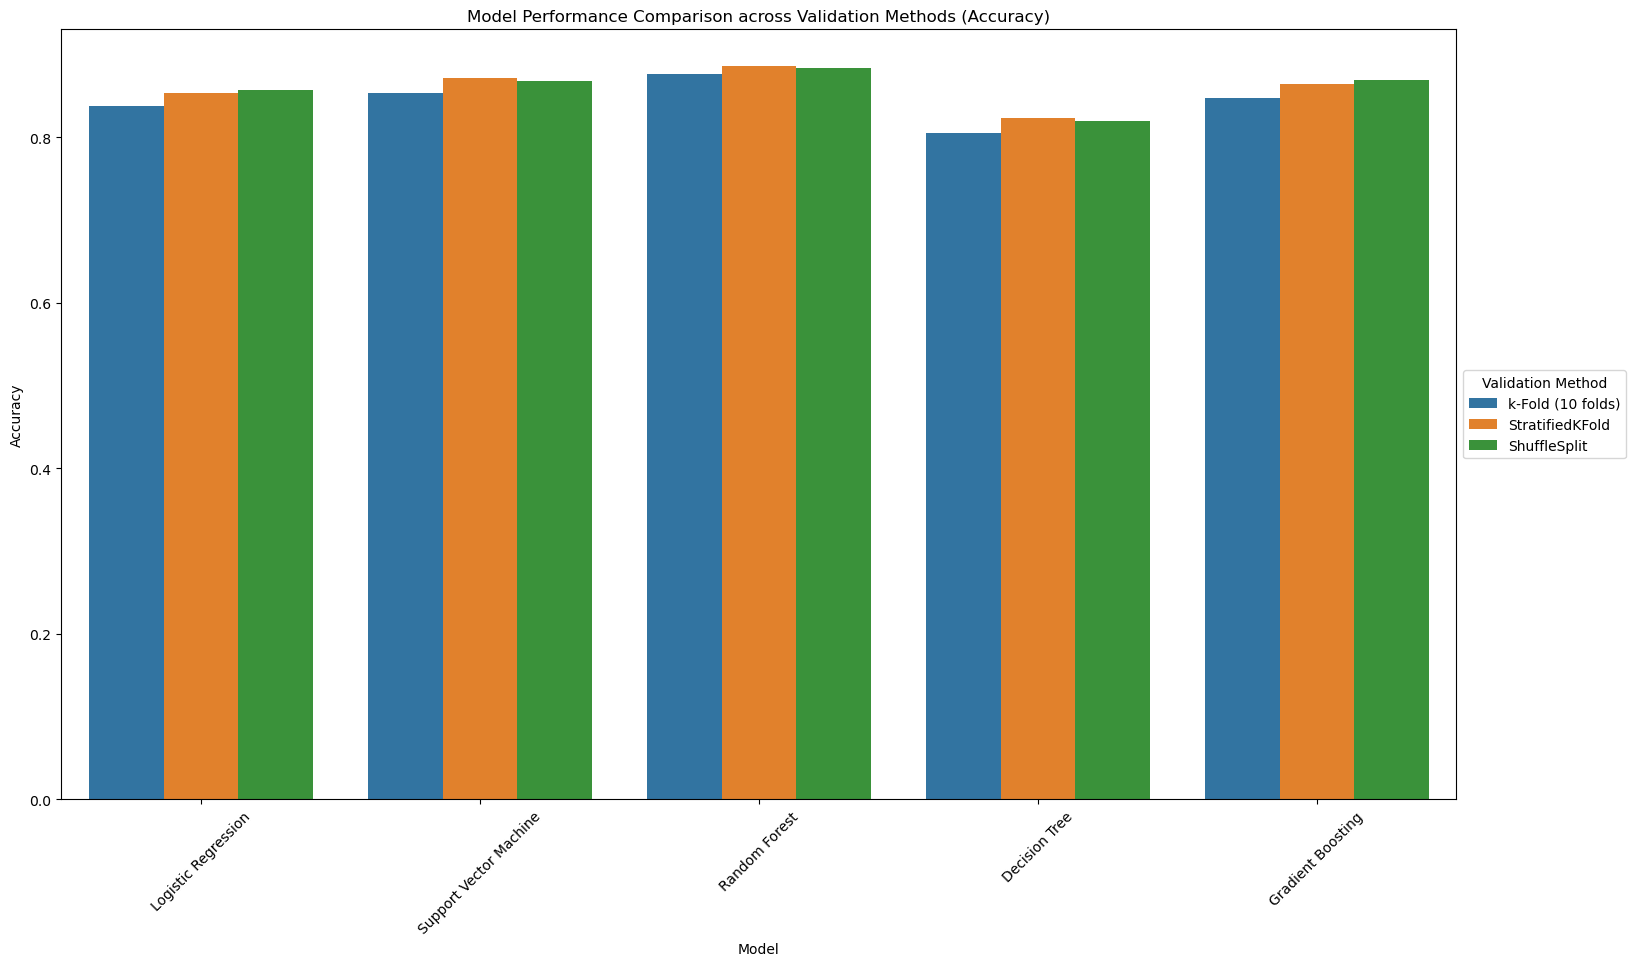

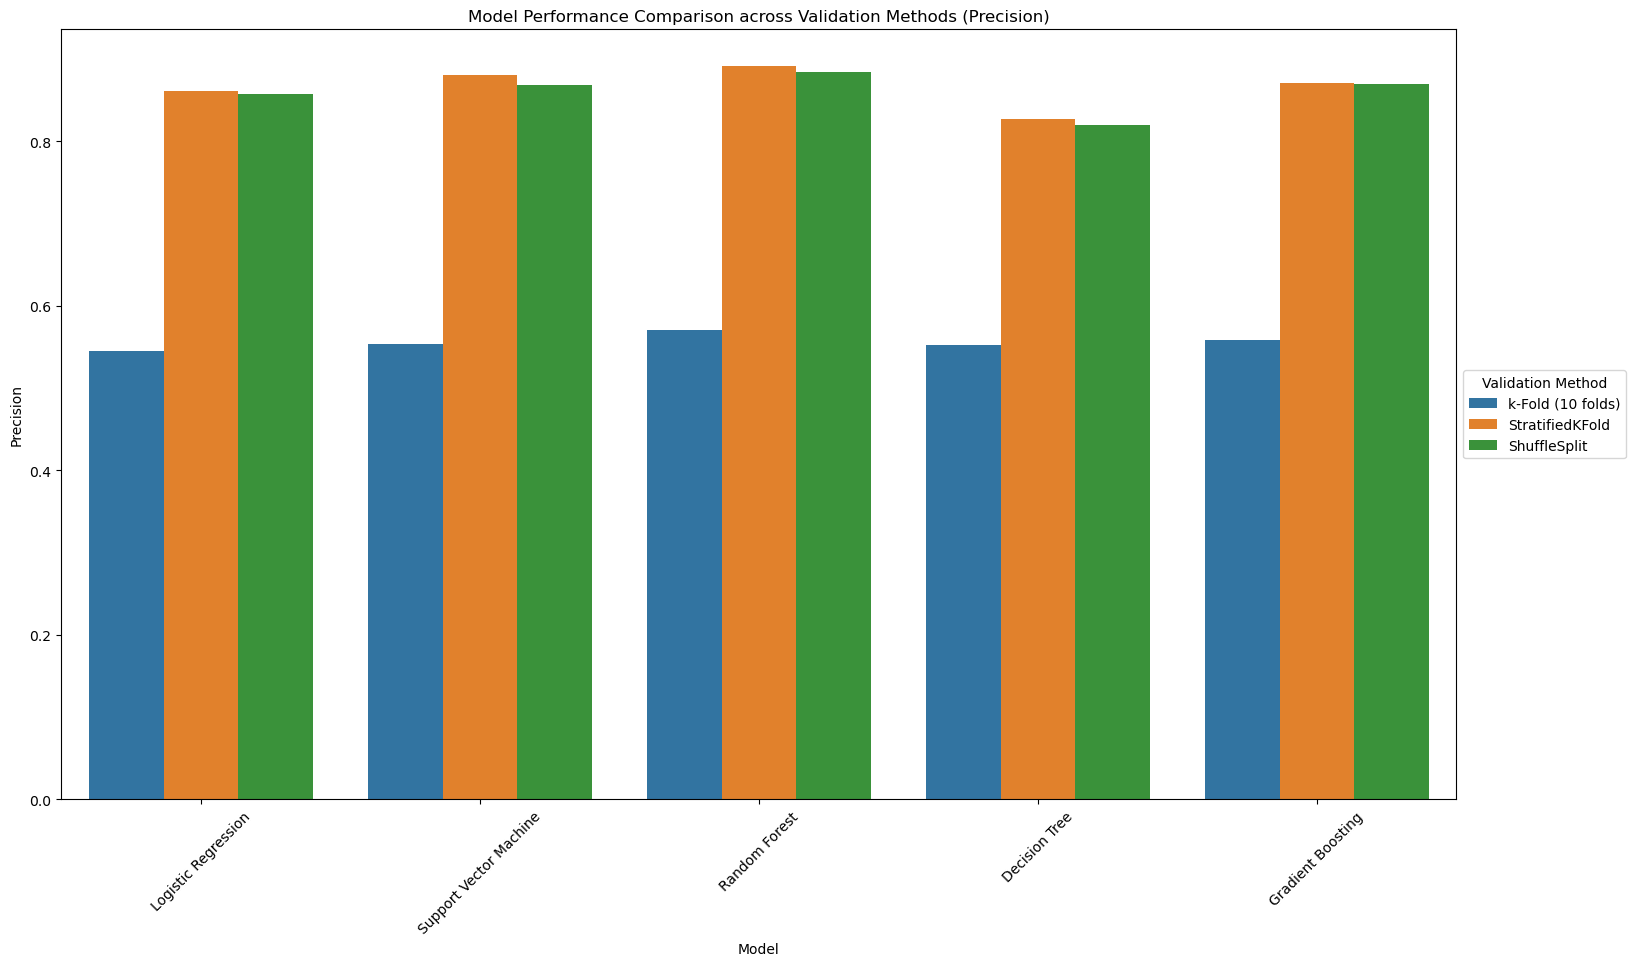

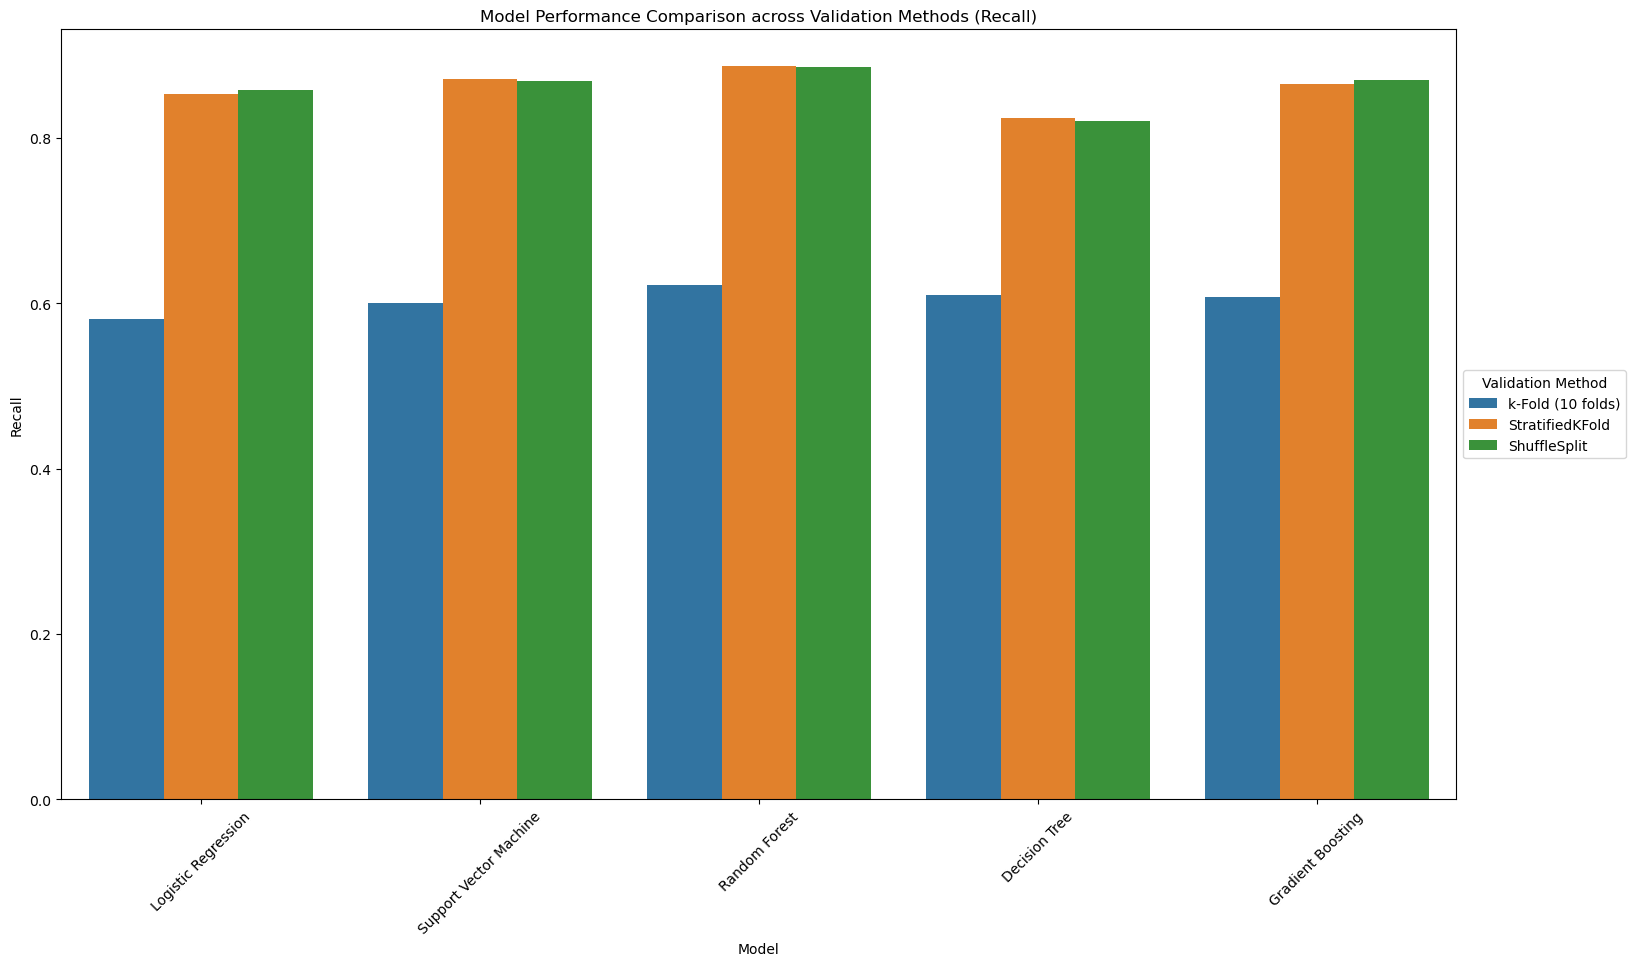

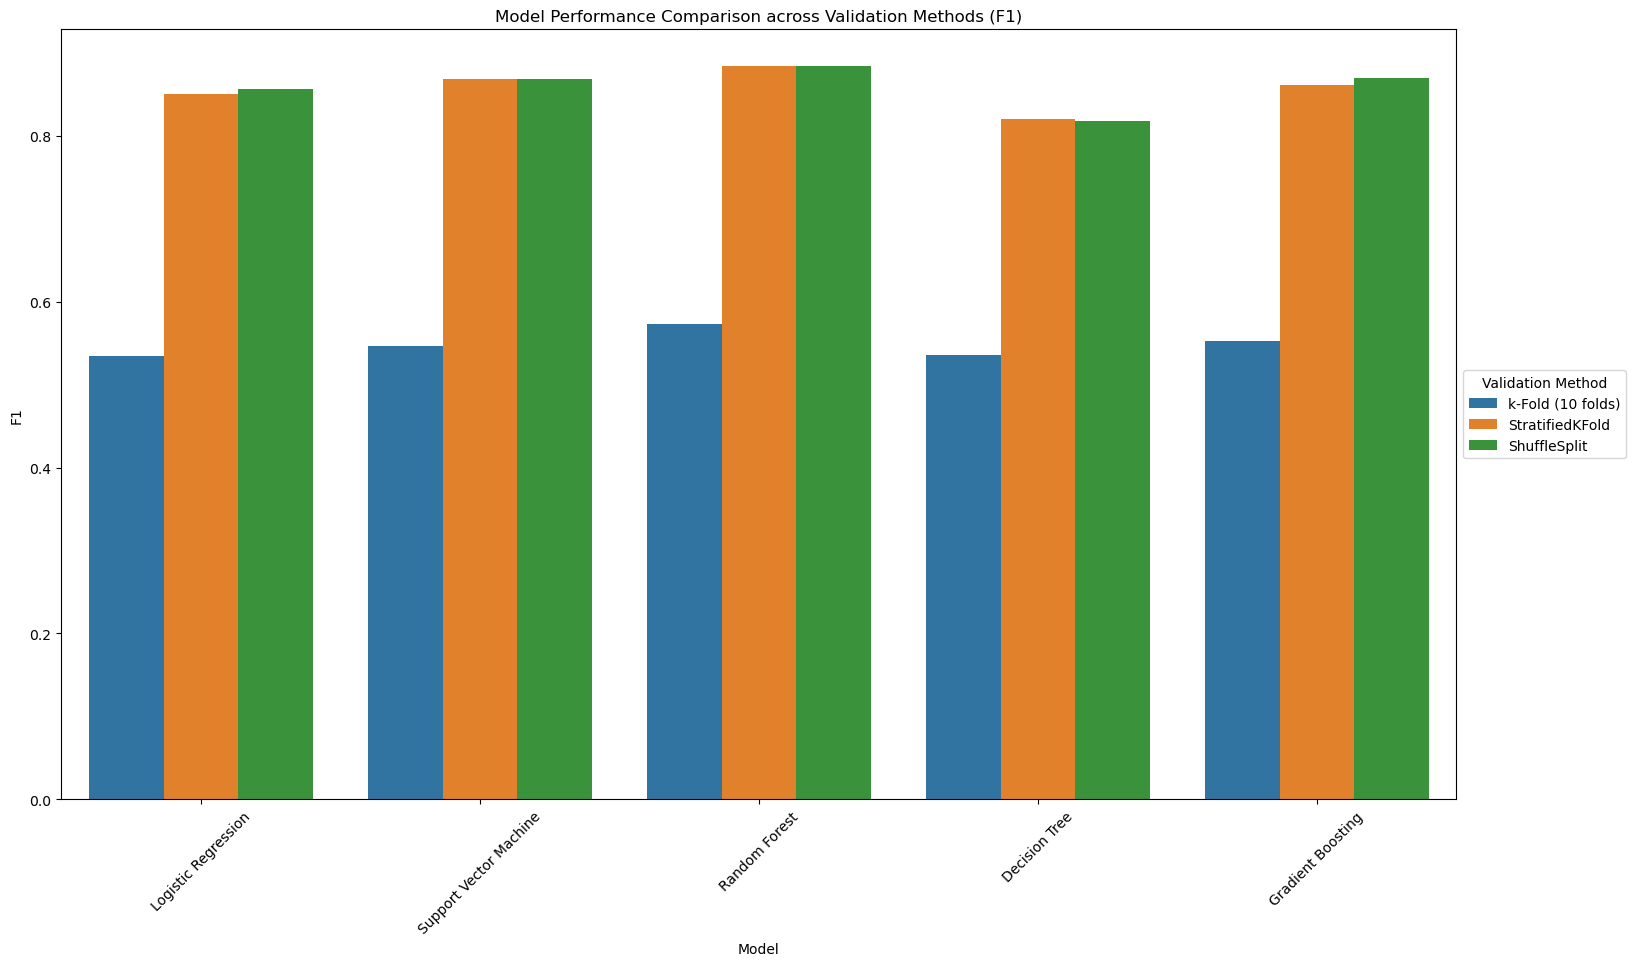

In [20]:
metrics = ['accuracy', 'precision', 'recall', 'f1']
for metric in metrics:
    plt.figure(figsize=(18, 10))
    sns.barplot(x='Model', y='Mean', hue='Validation Method', data=combined_results_df[combined_results_df['Metric'] == metric], ci=None, capsize=0.1)
    plt.title(f'Model Performance Comparison across Validation Methods ({metric.capitalize()})')
    plt.ylabel(metric.capitalize())
    plt.xlabel('Model')
    plt.xticks(rotation=45)
    plt.legend(title='Validation Method',loc='center left', bbox_to_anchor=(1, 0.5))
    #plt.savefig(f'{metric}.png',dpi=350)